In [161]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa import seasonal
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler, StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

import missingno as msno

import math

import warnings # Supress warnings
warnings.filterwarnings('ignore')

## Load data from kaggle


In [6]:
import os
from pathlib import Path

_data_root = os.path.join("./../", 'data')
_data_root_raw = os.path.join(_data_root, 'raw')

In [7]:
isExist = os.path.exists(f"{_data_root}/store-sales-time-series-forecasting.zip")
if not isExist:
    !kaggle competitions download -c store-sales-time-series-forecasting -p {_data_root} --force

!unzip -o {_data_root}/"store-sales-time-series-forecasting.zip" -d {_data_root}
!mv {_data_root + "/*.csv"} {_data_root_raw}

Archive:  ./../data/store-sales-time-series-forecasting.zip
  inflating: ./../data/holidays_events.csv  
  inflating: ./../data/oil.csv       
  inflating: ./../data/sample_submission.csv  
  inflating: ./../data/stores.csv    
  inflating: ./../data/test.csv      
  inflating: ./../data/train.csv     
  inflating: ./../data/transactions.csv  


In [75]:
holidays_events = pd.read_csv(
    f"{_data_root_raw}/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')
holidays_events_start = holidays_events.copy()

oil = pd.read_csv(
    f"{_data_root_raw}/oil.csv",
    parse_dates=['date'],
    infer_datetime_format=True,
    index_col= 'date'
).to_period('D')
oil_start = oil.copy()

store_sales = pd.read_csv(
    f"{_data_root_raw}/train.csv",
    usecols=['date', 'store_nbr', 'family', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        #'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['date', 'store_nbr', 'family']).sort_index()
store_sales_start = store_sales.copy()

test_data = pd.read_csv(
    f"{_data_root_raw}/test.csv",
    usecols = ['date', 'store_nbr', 'family'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        #'onpromotion': 'uint32'
    },
    parse_dates=['date'],
    date_parser= lambda x: pd.to_datetime(x, format='%Y-%m-%d').to_period('D'),
    infer_datetime_format=True,
    index_col=['date', 'store_nbr', 'family']
)

test_data_start = test_data.copy()

stores_df = pd.read_csv(f"{_data_root_raw}/stores.csv",
                        dtype={
                            'store_nbr': 'category',
                            'city': 'category',
                            'state': 'category',
                            'cluster': 'category'
                        }, usecols=['store_nbr', 'city', 'state', 'cluster', 'type']
                        )
stores_df_start = stores_df.copy()

In [76]:
store_sales.tail()

sales
date       store_nbr family                                 
2017-08-15 9         POULTRY                      438.132996
                     PREPARED FOODS               154.552994
                     PRODUCE                     2419.729004
                     SCHOOL AND OFFICE SUPPLIES   121.000000
                     SEAFOOD                       16.000000

In [77]:
test_data.tail()

Empty DataFrame
Columns: []
Index: [(2017-08-31, 9, POULTRY), (2017-08-31, 9, PREPARED FOODS), (2017-08-31, 9, PRODUCE), (2017-08-31, 9, SCHOOL AND OFFICE SUPPLIES), (2017-08-31, 9, SEAFOOD)]

### Check for null data:

In [192]:
store_sales.isna().sum()

sales    0
dtype: int64

In [13]:
holidays_events.isna().sum()

type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [14]:
oil_start.isna().sum()

dcoilwtico    43
dtype: int64

<AxesSubplot: >

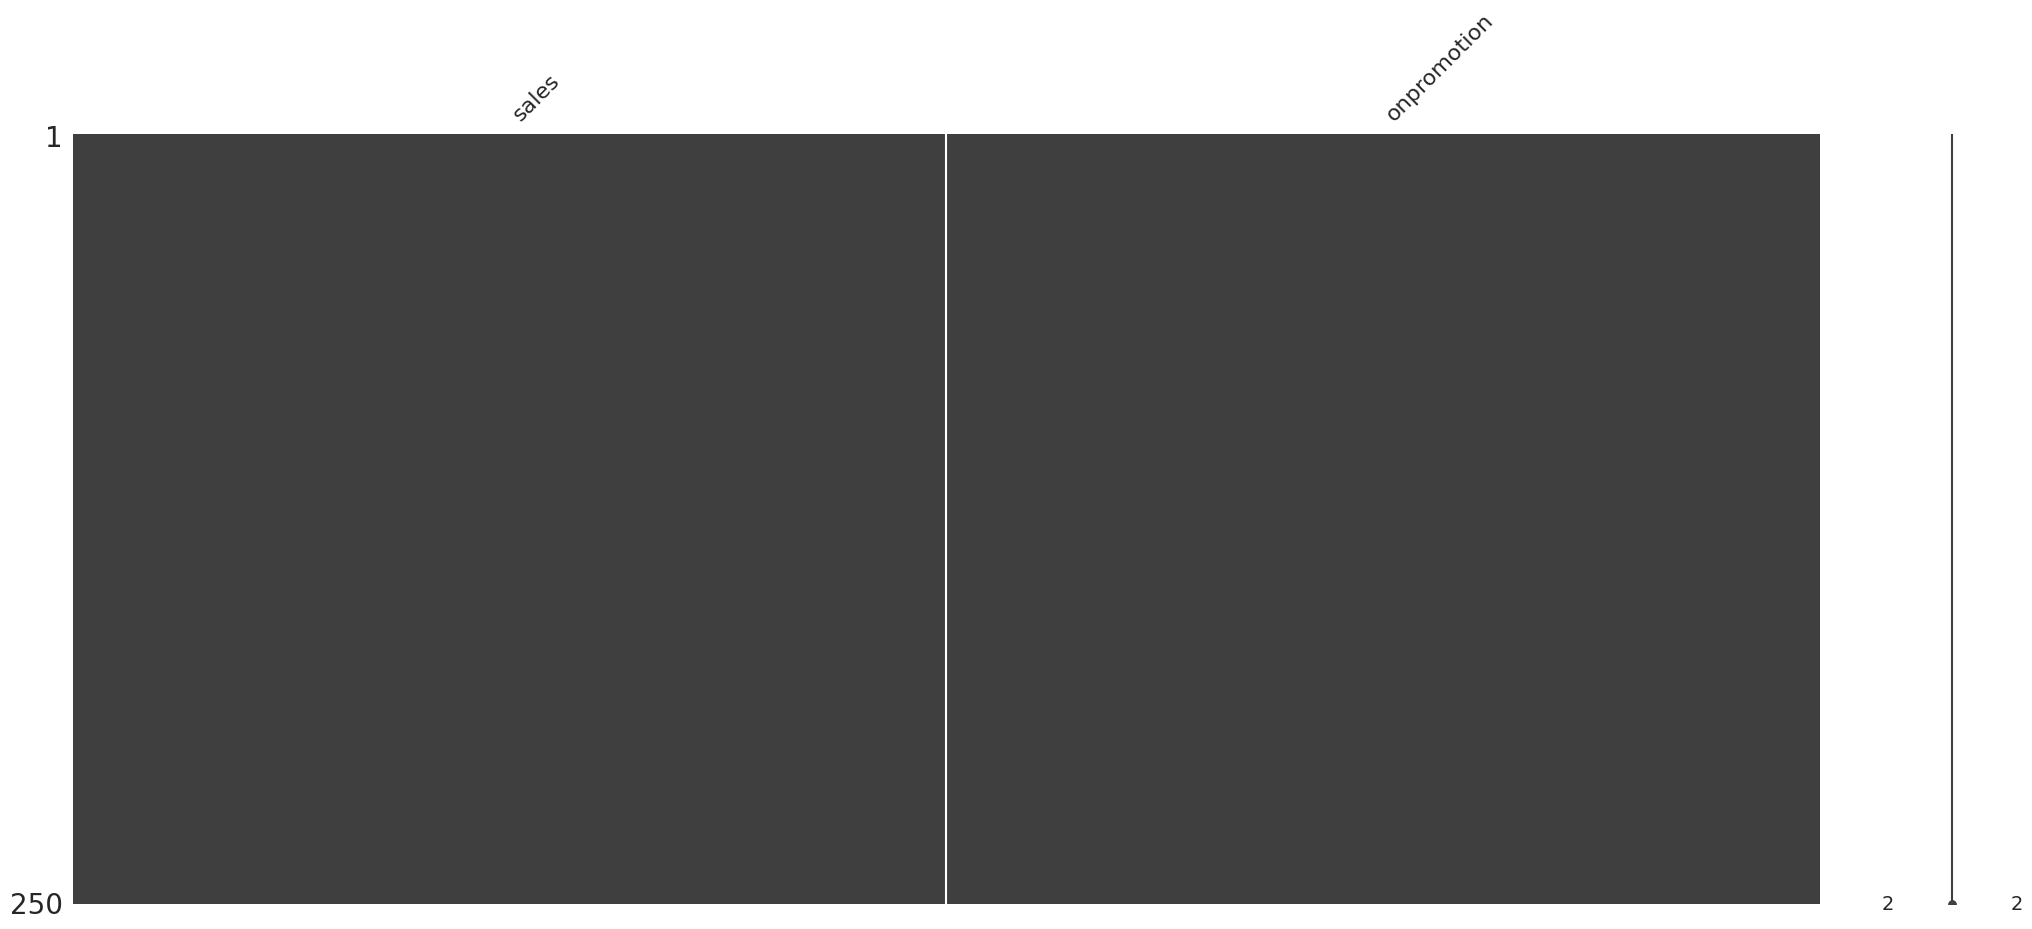

In [88]:
%matplotlib inline
msno.matrix(store_sales.sample(250))

<AxesSubplot: >

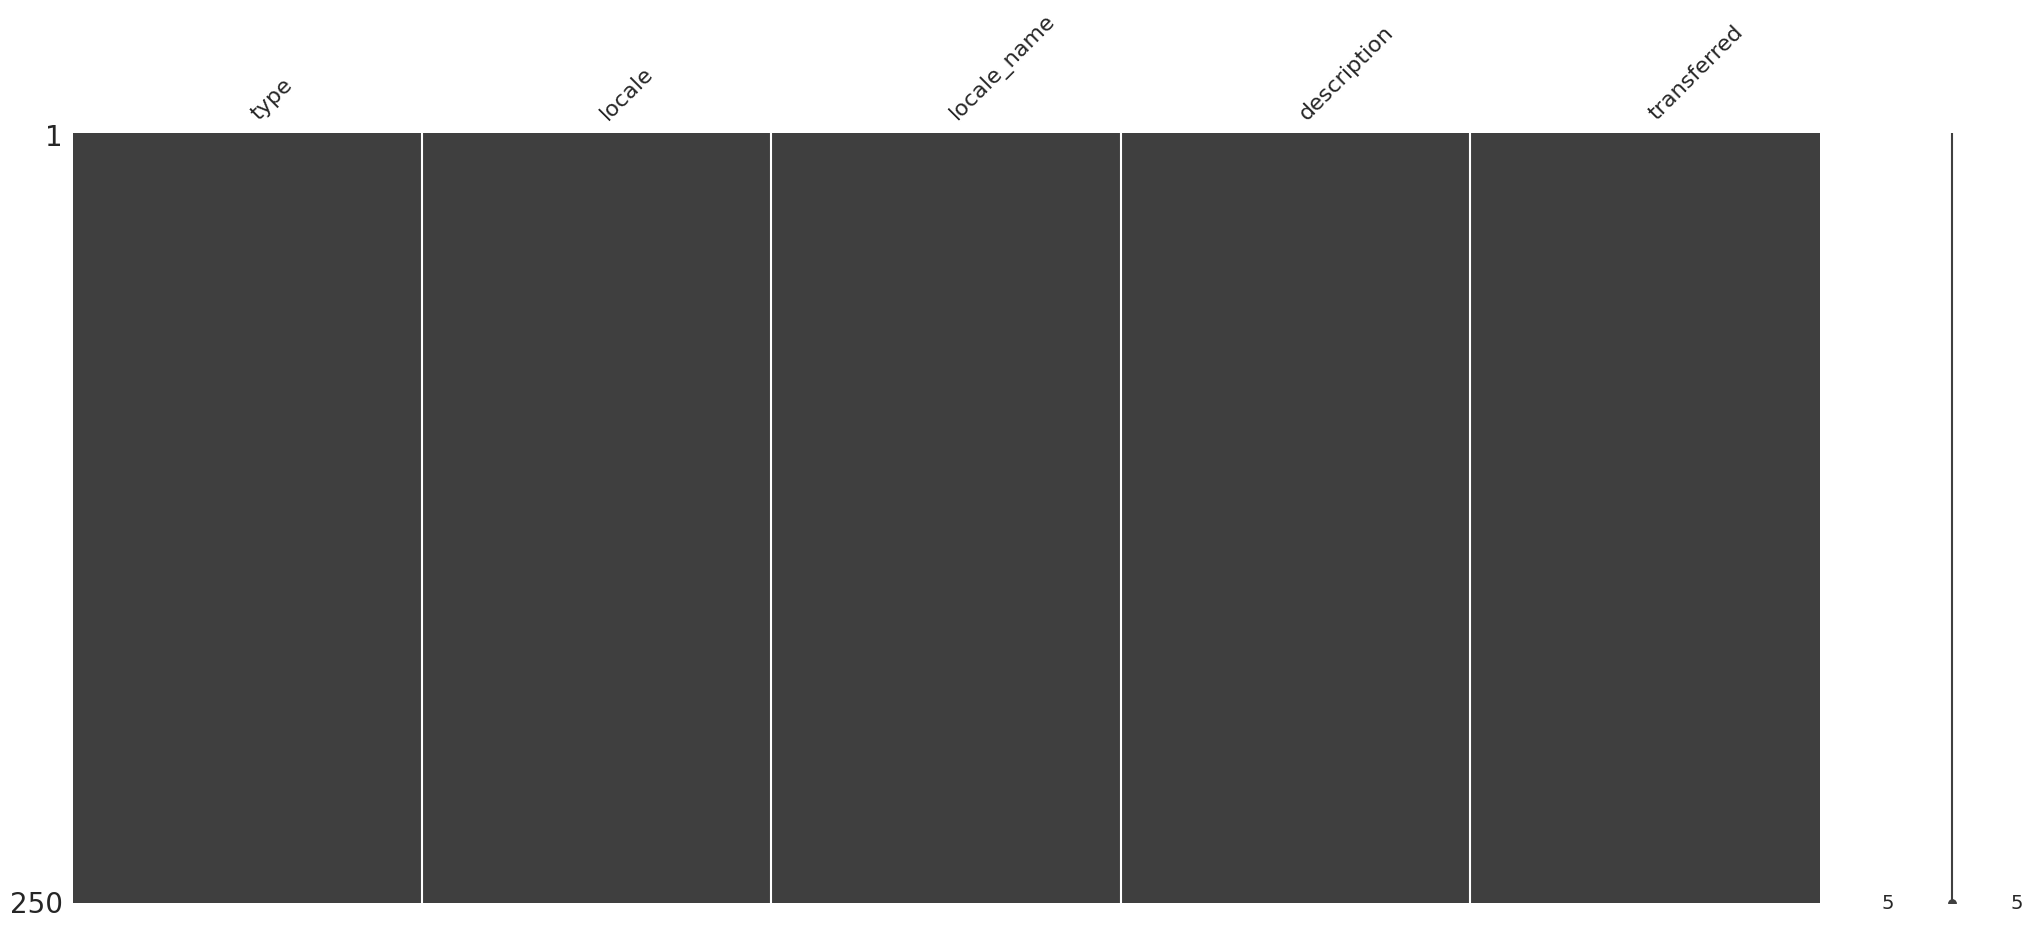

In [15]:
%matplotlib inline
msno.matrix(holidays_events.sample(250))

In [16]:
stores_df_start.isna().sum()

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

In [79]:
family_2017_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017', ['sales']]
)

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc[:, ['sales']]
)


In [18]:
family_sales.index.names

FrozenList(['date'])

<AxesSubplot: xlabel='date'>

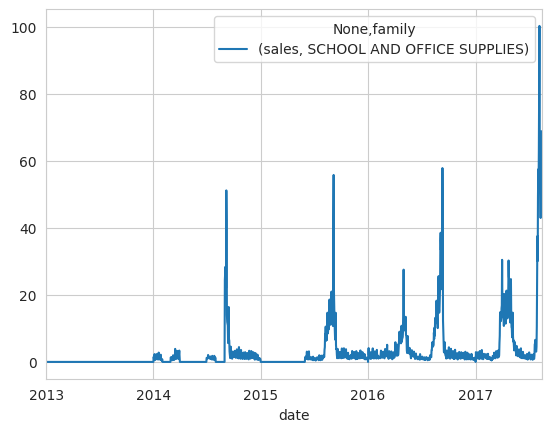

In [80]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
supply_sales.plot()


Check for seasonality

We see that there is strong seasonality ( lag-1, lag-7 (weekly)
There also other correlations to lag-3, lag-5, lag-6, lag-8, atc and even lag-21

Try Determnistic process, to capture seasonality

### Code for plotting and making lags etc

In [20]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


In [21]:
def make_leads(ts, leads, name='y'):
    return pd.concat(
        {f'{name}_lead_{i}': ts.shift(-i)
         for i in reversed(range(leads))},
        axis=1)


def make_lags(ts, lags, lead_time=1, name='y'):
    return pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)

class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None

    def fit(self, X_1, X_2, y, stack_cols=None):
        # Train model_1
        self.model_1.fit(X_1, y)

        # Make predictions
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=y.columns,
        )
        # Compute residuals
        y_resid = y - y_fit
        y_resid = y_resid.stack(stack_cols).squeeze()  # wide to long

        # Train model_2 on residuals
        self.model_2.fit(X_2, y_resid)

        # Save column names for predict method
        self.y_columns = y.columns
        self.stack_cols = stack_cols

    def predict(self, X_1, X_2):
        # Predict with model_1
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()  # wide to long

        # Add model_2 predictions to model_1 predictions
        y_pred += self.model_2.predict(X_2)
        return y_pred.unstack(self.stack_cols)

def create_lags(df, target_col, lags=1, suffix='_lag', drop_target=True):
    for i in range(1, lags + 1) :
        df[f'{target_col}({suffix}{i})'] = df[target_col].shift(i)
    if drop_target:
        df = df.drop(columns=[target_col])
    return df

#### Multistep functions

In [22]:
def make_multistep_target(ts, steps, reverse=False):
    shifts = reversed(range(steps)) if reverse else range(steps)
    return pd.concat({f'y_step_{i + 1}': ts.shift(-i) for i in shifts}, axis=1)


def create_multistep_example(n, steps, lags, lead_time=1, start='2013'):
    ts = pd.Series(
        np.arange(n),
        index=pd.period_range(start=start, freq='A', periods=n, name='Year'),
        dtype=pd.Int8Dtype,
    )
    X = make_lags(ts, lags, lead_time)
    y = make_multistep_target(ts, steps, reverse=True)
    data = pd.concat({'Targets': y, 'Features': X}, axis=1)
    data = data.style.set_properties(['Targets'], **{'background-color': 'LavenderBlush'}) \
        .set_properties(['Features'], **{'background-color': 'Lavender'})
    return data


def load_multistep_data():
    df1 = create_multistep_example(10, steps=1, lags=3, lead_time=1)
    df2 = create_multistep_example(10, steps=3, lags=4, lead_time=2)
    df3 = create_multistep_example(10, steps=3, lags=4, lead_time=1)
    return [df1, df2, df3]


def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

### Functions to create features

#### Make features for oil

In [81]:
oil['avg_oil'] = oil['dcoilwtico'].rolling(7).mean()
oil.head(20)

,dcoilwtico,avg_oil
date,,
2013-01-01,NaN,NaN
2013-01-02,93.14,NaN
2013-01-03,92.97,NaN
2013-01-04,93.12,NaN
2013-01-07,93.20,NaN
2013-01-08,93.21,NaN
2013-01-09,93.08,NaN
2013-01-10,93.81,93.218571
2013-01-11,93.60,93.284286


In [82]:
def create_oil_features(oil_df=oil_start):
    oil_df['dcoilwtico'].fillna(method = 'bfill', inplace = True)
    oil_df['avg_oil'] = oil_df['dcoilwtico'].rolling(7).mean().fillna(method = 'ffill').fillna(method = 'bfill')

    oil_df.drop(["dcoilwtico"], axis=1, inplace = True)
    return oil_df

def create_oil_feature_from_start():
    return create_oil_features(oil_df=oil_start.copy())

oil_df_feature = create_oil_features(oil_df=oil_start.copy())
print(oil_df_feature.isna().sum())
oil_df_feature.head(50)

avg_oil    0
dtype: int64


,avg_oil
date,
2013-01-01,93.122857
2013-01-02,93.122857
2013-01-03,93.122857
2013-01-04,93.122857
2013-01-07,93.122857
2013-01-08,93.122857
2013-01-09,93.122857
2013-01-10,93.218571
2013-01-11,93.284286


<AxesSubplot: xlabel='date'>

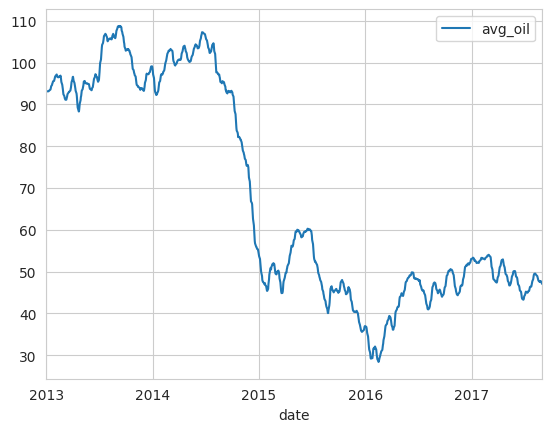

In [83]:
oil_df_feature.plot()

#### Create features for holidays calendar

In [200]:
%%time

def create_calendar_df(holidays_events_df: pd.DataFrame = holidays_events):
    days_range = pd.Series(pd.date_range('2013-01-01', '2017-08-31').to_period('D'), name='date')

    calendar_df = pd.DataFrame(index=days_range)

    # merge holidays with calendar df
    calendar_df = calendar_df.merge(holidays_events_df, how='left', on=['date'])
    calendar_df = calendar_df.sort_index()

    calendar_df["type"].fillna("Work Day", inplace = True)
    calendar_df["locale"].fillna("National", inplace = True)
    calendar_df["locale_name"].fillna("Ecuador", inplace = True)
    #calendar_df["description"].fillna("Some Holiday", inplace = True)
    calendar_df["transferred"].fillna(False, inplace = True)
    return calendar_df

def make_calendar_features(calendar_df: pd.DataFrame):
    # set workday feature as all non-holiday
    calendar_df['work_day'] = True
    calendar_df.loc[calendar_df.type == 'Bridge', 'work_day'] = False
    calendar_df.loc[calendar_df.type == 'Transfer', 'work_day'] = False
    calendar_df.loc[(calendar_df.type == 'Additional') & (calendar_df.transferred == False), 'work_day'] = False
    calendar_df.loc[(calendar_df.type == 'Holiday') & (calendar_df.transferred == False), 'work_day'] = False

    calendar_df['isevent'] = False
    calendar_df.loc[calendar_df.type == 'Event', 'isevent'] = True

    calendar_df = pd.get_dummies(calendar_df, columns=['type'], drop_first=True)
    calendar_df = pd.get_dummies(calendar_df, columns=['locale'], drop_first=True)

    calendar_df.drop(columns=['locale_name', 'transferred'], inplace = True)

    # Reduce duplicate rows
    calendar_df = calendar_df.groupby('date').agg(lambda x: np.bitwise_or.reduce(x.values))

    return calendar_df

def add_calendar_features(calendar_df: pd.DataFrame):
    calendar_df['year'] = calendar_df.index.get_level_values('date').year.astype('int')
    calendar_df['quarter'] = calendar_df.index.get_level_values('date').quarter.astype('int')
    calendar_df['day_of_year'] = calendar_df.index.get_level_values('date').dayofyear.astype('int')
    calendar_df['week_of_year'] = calendar_df.index.get_level_values('date').weekofyear.astype('int')
    calendar_df['day_of_week'] = calendar_df.index.get_level_values('date').dayofweek.astype('int')
    calendar_df['is_weekend'] = calendar_df.index.get_level_values('date').dayofweek.isin((5, 6))
    calendar_df['begin_year'] = calendar_df.index.get_level_values('date').dayofyear == 1
    calendar_df['school'] = calendar_df.index.get_level_values('date').month.isin((4, 5, 8, 9)).astype('bool')
    calendar_df['wageday'] = ((calendar_df.index.get_level_values('date').to_timestamp().is_month_end) | (calendar_df.index.get_level_values('date').day == 15))


    return calendar_df

def create_calendar_features_from_start():
    calendar_df_features = create_calendar_df(holidays_events_df=holidays_events_start.copy())
    calendar_df_features = make_calendar_features(calendar_df_features)
    calendar_df_features = add_calendar_features(calendar_df_features)
    return calendar_df_features

CPU times: user 36 µs, sys: 0 ns, total: 36 µs
Wall time: 40.5 µs


In [201]:
calendar_df_features = create_calendar_features_from_start()
print(calendar_df_features.index.names)
calendar_df_features.head(20)

['date']


,work_day,isevent,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day,locale_National,locale_Regional,year,quarter,day_of_year,week_of_year,day_of_week,is_weekend,begin_year,school,wageday
date,,,,,,,,,,,,,,,,,,
2013-01-01,False,False,0,0,1,0,0,1,0,2013,1,1,1,1,False,True,False,False
2013-01-02,True,False,0,0,0,0,1,1,0,2013,1,2,1,2,False,False,False,False
2013-01-03,True,False,0,0,0,0,1,1,0,2013,1,3,1,3,False,False,False,False
2013-01-04,True,False,0,0,0,0,1,1,0,2013,1,4,1,4,False,False,False,False
2013-01-05,True,False,0,0,0,0,1,1,0,2013,1,5,1,5,True,False,False,False
2013-01-06,True,False,0,0,0,0,1,1,0,2013,1,6,1,6,True,False,False,False
2013-01-07,True,False,0,0,0,0,1,1,0,2013,1,7,2,0,False,False,False,False
2013-01-08,True,False,0,0,0,0,1,1,0,2013,1,8,2,1,False,False,False,False
2013-01-09,True,False,0,0,0,0,1,1,0,2013,1,9,2,2,False,False,False,False


#### Other feature engineering functions

In [93]:
def make_dummies(feature_df: pd.DataFrame):
    feature_df = pd.get_dummies(feature_df, columns=['year'], drop_first=True)
    feature_df = pd.get_dummies(feature_df, columns=['quarter'], drop_first=True)
    feature_df = pd.get_dummies(feature_df, columns=['day_of_week'], drop_first=True)

    return feature_df

def make_onpromotion_rolling_features(feature_df: pd.DataFrame):
    feature_df['onpromotion_week_avg'] = feature_df['onpromotion'].rolling(7).mean()
    feature_df['onpromotion_biweek_avg'] = feature_df['onpromotion'].rolling(14).mean()
    feature_df['onpromotion_1_month_avg'] = feature_df['onpromotion'].rolling(30).mean()
    feature_df['onpromotion_2_month_avg'] = feature_df['onpromotion'].rolling(60).mean()

    return feature_df


def drop_features(feature_df: pd.DataFrame):
    feature_df.drop(columns=['city', 'cluster', 'state', 'store_type'], inplace=True)
    return feature_df



##### Merge train and test data before feature engineering

##### Merge dataframes: train_test + stores + holidays functions

In [202]:
def create_final_feature_df(train_df, test_df):
    final_feature_df = train_df.copy()
    test_df_copy = test_df.copy()

    test_df_copy["sales"] = np.NaN

    final_feature_df = pd.concat([final_feature_df, test_df_copy], axis=0)
    print(f'index_columns: {final_feature_df.index.names}')
    return final_feature_df


def merge_feature_df(feature_df, stores_df_features=None, calendar_df_features=None):
    # merge to store features
    if stores_df_features is not None:
        feature_df = feature_df.merge(stores_df_features, how='left', left_index=True, right_index=True)
        feature_df.drop(feature_df.filter(regex='_y$').columns, axis=1, inplace=True)

    # merge to holidays
    if calendar_df_features is not None:
        feature_df = feature_df.merge(calendar_df_features, how='left', left_index=True, right_index=True, suffixes=('', '_y'))
        feature_df.drop(feature_df.filter(regex='_y$').columns, axis=1, inplace=True) # Drop common columns after merge

    return feature_df

def merge_calendar_oil(calendar_df, oil_df):
    calendar_merged_df = calendar_df.copy()
    calendar_merged_df = calendar_merged_df.merge(oil_df, how='left', left_index=True, right_index=True)
    calendar_merged_df['avg_oil'].fillna(method = 'ffill', inplace = True)
    return calendar_merged_df

def make_dp_fourier_features(y): # feature_df has to be unstacked
    #y = feature_df.loc[:, 'sales']

    #fourierA = CalendarFourier(freq='A', order=5) # annual
    fourierM = CalendarFourier(freq='M', order=2) # monthly
    fourierW = CalendarFourier(freq='W', order=3) # weekly

    dp = DeterministicProcess(index=y.index,
                              order=1,
                              seasonal=True,
                              constant=False,
                              additional_terms=[#fourierA,
                                                fourierM,
                                                fourierW],
                              drop=True
                              )

    #dp_df = dp.in_sample()
    #feature_df = pd.concat([feature_df.reset_index(level=['store_nbr', 'family']), dp_df], axis=1)
    #feature_df = feature_df.set_index(['store_nbr', 'family'], append=True)
    return dp

final_feature_df = create_final_feature_df(train_df=store_sales_start, test_df=test_data_start)
final_feature_df_unstacked = final_feature_df.unstack(['store_nbr', 'family'])
y_unstacked = final_feature_df_unstacked.copy()
print(final_feature_df_unstacked.columns.names)
final_feature_df_unstacked.sample(5)

index_columns: ['date', 'store_nbr', 'family']
[None, 'store_nbr', 'family']


sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2015-10-24        4.0       0.0    1.0    2290.0   0.0   374.401001   
2015-06-16        3.0       0.0    6.0    2173.0   0.0   400.997986   
2014-06-15        0.0       0.0    2.0     347.0   0.0   111.699997   
2014-09-19        6.0       0.0    0.0    1944.0   0.0   365.487000   
2013-07-13        2.0       0.0    3.0     890.0   0.0   251.919998   

                                                    ...                        \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2015-10-24        15.0    606.0  790.0  204.822006  ...      11.0  365.544983   
2015-06-16        19.0    767.0  833.0  165.878006  ...       0.0  326.274017   
2014-06-15         0.0    130.0  182.0   19.768000  ...       0.0  335.407990   
2014-09-19        25.0    705.0  641.0  142.748993  ...       0.0  214.912003   
2013-07-13         0.0    520.0  398.0  106.893997  ...       0.0  363.127014   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2015-10-24         504.0          1.0                    26.0  532.487000   
2015-06-16         484.0          4.0                     8.0  444.135010   
2014-06-15         458.0          0.0                     0.0  680.411011   
2014-09-19         207.0          2.0                     6.0  350.255005   
2013-07-13         415.0          0.0                     0.0  464.415009   

                                                                              
store_nbr                                                                     
family     PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                          
2015-10-24      67.560997  1444.989014                        0.0   9.689000  
2015-06-16      61.393002  2405.339111                        9.0   4.000000  
2014-06-15      78.528999     0.000000                        0.0  14.197001  
2014-09-19      55.783001   869.026978                        0.0   5.677000  
2013-07-13      88.000000     0.000000                        0.0  15.516000  

[5 rows x 1782 columns]

In [247]:
final_feature_df

sales
date       store_nbr family                           
2013-01-01 1         AUTOMOTIVE                    0.0
                     BABY CARE                     0.0
                     BEAUTY                        0.0
                     BEVERAGES                     0.0
                     BOOKS                         0.0
...                                                ...
2017-08-31 9         POULTRY                       NaN
                     PREPARED FOODS                NaN
                     PRODUCE                       NaN
                     SCHOOL AND OFFICE SUPPLIES    NaN
                     SEAFOOD                       NaN

[3029400 rows x 1 columns]

In [75]:
final_feature_df_unstacked.loc[:, "sales"]

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...               ...       ...    ...       ...   ...          ...   
2017-08-27        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-28        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-29        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-30        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-31        NaN       NaN    NaN       NaN   NaN          NaN   

store_nbr                                           ...         9              \
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2013-01-01         0.0      0.0    0.0    0.000000  ...       0.0    0.000000   
2013-01-02         0.0   1060.0  579.0  164.069000  ...       0.0  374.531006   
2013-01-03         0.0    836.0  453.0  151.582001  ...       0.0  400.863007   
2013-01-04         0.0    827.0  460.0  131.410995  ...       0.0  310.877991   
2013-01-05         0.0    811.0  464.0  118.612999  ...       0.0  447.684998   
...                ...      ...    ...         ...  ...       ...         ...   
2017-08-27         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-28         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-29         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-30         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-31         NaN      NaN    NaN         NaN  ...       NaN         NaN   

store_nbr                                                                  \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2013-01-01           0.0          0.0                     0.0    0.000000   
2013-01-02         482.0          0.0                     0.0  651.291992   
2013-01-03         372.0          0.0                     0.0  509.496002   
2013-01-04         324.0          0.0                     0.0  332.671997   
2013-01-05         461.0          0.0                     0.0  510.919006   
...                  ...          ...                     ...         ...   
2017-08-27           NaN          NaN                     NaN         NaN   
2017-08-28           NaN          NaN                     NaN         NaN   
2017-08-29           NaN          NaN                     NaN         NaN   
2017-08-30           NaN          NaN                     NaN         NaN   
2017-08-31           NaN          NaN                     NaN         NaN   

store_nbr                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                     
2013-01-01            0.0     0.0                        0.0   0.000000  
2013-01-02           83.0     0.0                        0.0  29.214001  
2013-01-03           66.0     0.0                        0.0  25.000000  
2013-01-04           57.0     0.0                        0.0  11.000000  
2013-01-05           84.0     0.0                        0.0  28.361000  
...                   ...     ...                        ...        ...  
2017-08-27            NaN     NaN                        NaN        NaN  
2017-08-28            NaN     NaN                  

In [203]:
calendar_df_features = create_calendar_features_from_start()
oil_df_feature = create_oil_features(oil_df=oil_start.copy())
final_feature_df = create_final_feature_df(train_df=store_sales_start, test_df=test_data_start)
final_feature_df_unstacked = final_feature_df.unstack(['store_nbr', 'family'])
y_unstacked = final_feature_df_unstacked.copy()
calendar_df_merged = merge_calendar_oil(calendar_df_features, oil_df_feature)

dp = make_dp_fourier_features(y_unstacked)
final_feature_df_unstacked_after_dp = dp.in_sample()
final_feature_df_merged_calendar = merge_feature_df(feature_df=final_feature_df_unstacked_after_dp, calendar_df_features=calendar_df_merged)
final_feature_df_merged_calendar_with_dummies = make_dummies(final_feature_df_merged_calendar)
display(final_feature_df_merged_calendar_with_dummies)
display(final_feature_df_unstacked_after_dp)
display(y_unstacked)

index_columns: ['date', 'store_nbr', 'family']


,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,year_2017,quarter_2,quarter_3,quarter_4,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,1,0,0,0,0,0
2013-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,...,0,0,0,0,0,1,0,0,0,0
2013-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,...,0,0,0,0,0,0,1,0,0,0
2013-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,...,0,0,0,0,0,0,0,1,0,0
2013-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,1696.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.848644,0.528964,...,1,0,1,0,0,0,0,0,0,1
2017-08-28,1697.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.724793,0.688967,...,1,0,1,0,0,0,0,0,0,0
2017-08-29,1698.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.571268,0.820763,...,1,0,1,0,1,0,0,0,0,0


,trend,"s(1,7)","s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)"
date,,,,,,,,,,,,,,,,,,
2013-01-01,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.000000,1.000000,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969
2013-01-02,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.201299,0.979530,0.394356,0.918958,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490
2013-01-03,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.394356,0.918958,0.724793,0.688967,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521
2013-01-04,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.571268,0.820763,0.937752,0.347305,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521
2013-01-05,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.724793,0.688967,0.998717,-0.050649,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.623490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,1696.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.848644,0.528964,-0.897805,-0.440394,-0.781831,0.623490,-0.974928,-0.222521,-0.433884,-0.900969
2017-08-28,1697.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.724793,0.688967,-0.998717,-0.050649,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
2017-08-29,1698.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.571268,0.820763,-0.937752,0.347305,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969


sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2013-01-01        0.0       0.0    0.0       0.0   0.0     0.000000   
2013-01-02        2.0       0.0    2.0    1091.0   0.0   470.652008   
2013-01-03        3.0       0.0    0.0     919.0   0.0   310.654999   
2013-01-04        3.0       0.0    3.0     953.0   0.0   198.365997   
2013-01-05        5.0       0.0    3.0    1160.0   0.0   301.057007   
...               ...       ...    ...       ...   ...          ...   
2017-08-27        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-28        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-29        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-30        NaN       NaN    NaN       NaN   NaN          NaN   
2017-08-31        NaN       NaN    NaN       NaN   NaN          NaN   

                                                    ...                        \
store_nbr                                           ...         9               
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2013-01-01         0.0      0.0    0.0    0.000000  ...       0.0    0.000000   
2013-01-02         0.0   1060.0  579.0  164.069000  ...       0.0  374.531006   
2013-01-03         0.0    836.0  453.0  151.582001  ...       0.0  400.863007   
2013-01-04         0.0    827.0  460.0  131.410995  ...       0.0  310.877991   
2013-01-05         0.0    811.0  464.0  118.612999  ...       0.0  447.684998   
...                ...      ...    ...         ...  ...       ...         ...   
2017-08-27         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-28         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-29         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-30         NaN      NaN    NaN         NaN  ...       NaN         NaN   
2017-08-31         NaN      NaN    NaN         NaN  ...       NaN         NaN   

                                                                           \
store_nbr                                                                   
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2013-01-01           0.0          0.0                     0.0    0.000000   
2013-01-02         482.0          0.0                     0.0  651.291992   
2013-01-03         372.0          0.0                     0.0  509.496002   
2013-01-04         324.0          0.0                     0.0  332.671997   
2013-01-05         461.0          0.0                     0.0  510.919006   
...                  ...          ...                     ...         ...   
2017-08-27           NaN          NaN                     NaN         NaN   
2017-08-28           NaN          NaN                     NaN         NaN   
2017-08-29           NaN          NaN                     NaN         NaN   
2017-08-30           NaN          NaN                     NaN         NaN   
2017-08-31           NaN          NaN                     NaN         NaN   

                                                                         
store_nbr                                                                
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                     
2013-01-01            0.0     0.0                        0.0   0.000000  
2013-01-02           83.0     0.0                        0.0  29.214001  
2013-01-03           66.0     0.0                        0.0  25.000000  
2013-01-04           57.0     0.0                        0.0

Add Time-dependend features, fourier terms and seasonal terms


In [204]:
def split_data_train_test(df, train_df_start_date, train_df_end_date, test_df_start_date, test_df_end_date):
    df_train = df.loc[train_df_start_date: train_df_end_date]
    df_test = df.loc[test_df_start_date: test_df_end_date]
    return df_train, df_test


def separate_X_and_y(df, target='sales'):
    y = df[target].values
    X = df.drop(columns=target)
    return X, y

X_train, X_test = split_data_train_test(final_feature_df_merged_calendar_with_dummies, train_df_start_date='2013-01-01', train_df_end_date='2017-08-15',
                                        test_df_start_date='2017-08-16', test_df_end_date='2017-08-31')
y_train, _ = split_data_train_test(y_unstacked, train_df_start_date='2013-01-01', train_df_end_date='2017-08-15',
                                        test_df_start_date='2017-08-16', test_df_end_date='2017-08-31')

X, y = X_train.copy(), y_train.copy()

#X, y = X.loc['2017'], y.loc['2017']

In [205]:
#X_train
model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
#model = LinearRegression(fit_intercept=True, normalize=True)
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

y_pred = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()

y_target['sales_pred'] = y_pred['sales'].clip(0.) # Sales should be >= 0
print('RMSLE : ', np.sqrt(mean_squared_log_error(y_target['sales'], y_target['sales_pred'])))
y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred']))

RMSLE :  1.155744206430799


family
AUTOMOTIVE                     0.342120
BABY CARE                      0.046695
BEAUTY                         0.279652
BEVERAGES                      2.200282
BOOKS                          0.033814
BREAD/BAKERY                   1.193510
CELEBRATION                    1.135249
CLEANING                       1.643545
DAIRY                          1.367771
DELI                           0.935380
EGGS                           0.740414
FROZEN FOODS                   1.045356
GROCERY I                      2.503493
GROCERY II                     0.491818
HARDWARE                       0.282079
HOME AND KITCHEN I             1.589055
HOME AND KITCHEN II            1.157038
HOME APPLIANCES                0.150680
HOME CARE                      6.650432
LADIESWEAR                     0.975242
LAWN AND GARDEN                0.385981
LINGERIE                       0.501282
LIQUOR,WINE,BEER               1.928926
MAGAZINES                      0.390653
MEATS                          0.

In [146]:
#final_feature_df_unstacked.index

<AxesSubplot: xlabel='date'>

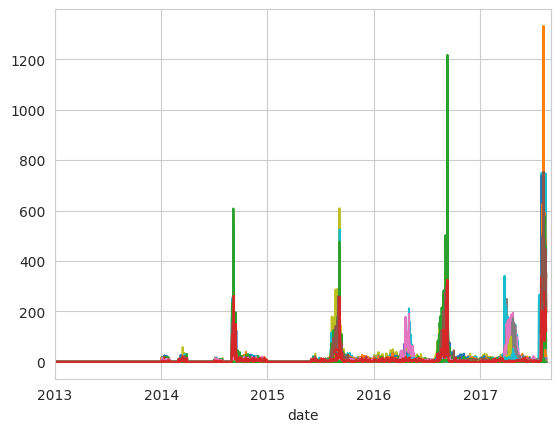

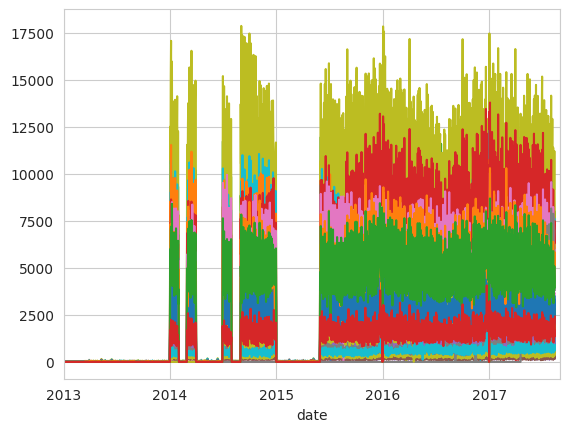

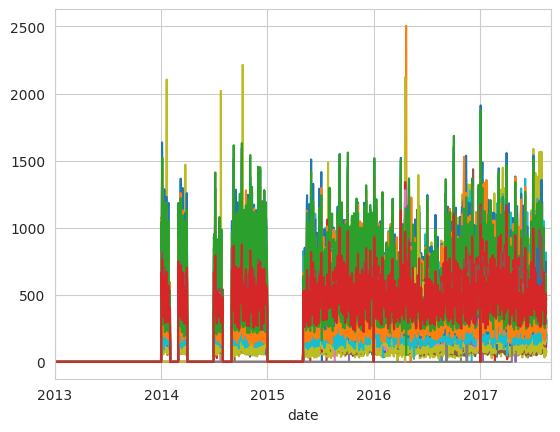

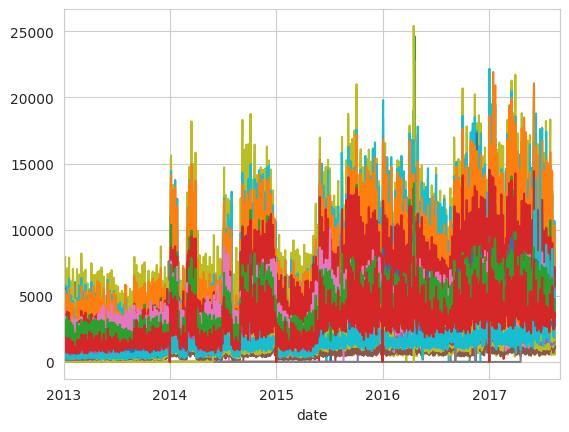

In [160]:
#stores_df_start.unstack(['store_nbr', 'family']).loc['2014':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)
final_feature_df_unstacked.loc['2013':].loc(axis=1)['sales', :, 'SCHOOL AND OFFICE SUPPLIES'].plot(legend=None)
final_feature_df_unstacked.loc['2013':].loc(axis=1)['sales', :, 'PRODUCE'].plot(legend=None)
final_feature_df_unstacked.loc['2013':].loc(axis=1)['sales', :, 'HOME CARE'].plot(legend=None)
final_feature_df_unstacked.loc['2013':].loc(axis=1)['sales', :, 'BEVERAGES'].plot(legend=None)


In [207]:
from tqdm.auto import tqdm
class CustomRegressor():

    def __init__(self, n_jobs=-1, verbose=0):
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.estimators_ = None

    def _estimator_(self, X, y):
        warnings.simplefilter(action='ignore', category=FutureWarning)
        if y.name[2] == 'SCHOOL AND OFFICE SUPPLIES':
            model = RandomForestRegressor(n_estimators = 300, n_jobs=-1, random_state=1)
        else:
            model = Ridge(fit_intercept=True, solver='auto', alpha=0.5, normalize=True)
        print(f'Fitting {y.name[2]}')
        model.fit(X, y)
        return model

    def fit(self, X, y):
        print('Fit Progress')
        self.estimators_ = Parallel(n_jobs=self.n_jobs,
                                    verbose=self.verbose,
                                    )(delayed(self._estimator_)(X, y.iloc[:, i]) for i in tqdm(range(y.shape[1])))
        return

    def predict(self, X):
        print('Predict Progress')
        y_pred = Parallel(n_jobs=self.n_jobs,
                          verbose=self.verbose)(delayed(e.predict)(X) for e in tqdm(self.estimators_))
        return np.stack(y_pred, axis=1)


In [183]:
y

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2017-03-01        1.0       0.0    3.0    3343.0   0.0   564.651978   
2017-03-02        3.0       0.0    8.0    2519.0   0.0   410.388000   
2017-03-03        5.0       0.0    9.0    2536.0   0.0   469.035004   
2017-03-04        6.0       0.0    5.0    2577.0   1.0   453.045990   
2017-03-05        0.0       0.0    1.0    1039.0   0.0   164.811005   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                     ...            \
store_nbr                                            ...         9   
family     CELEBRATION CLEANING   DAIRY        DELI  ... MAGAZINES   
date                                                 ...             
2017-03-01        14.0   1029.0  1162.0  165.751999  ...       6.0   
2017-03-02        22.0    924.0   848.0  129.167999  ...       4.0   
2017-03-03        22.0    903.0   890.0  181.996002  ...       7.0   
2017-03-04         7.0    752.0   898.0  132.485001  ...       6.0   
2017-03-05         2.0    250.0   345.0   75.792999  ...       1.0   
...                ...      ...     ...         ...  ...       ...   
2017-08-11         4.0    341.0   343.0   64.302002  ...       5.0   
2017-08-12         3.0    351.0   526.0   99.487999  ...       2.0   
2017-08-13         1.0    169.0   266.0   47.770000  ...       3.0   
2017-08-14         4.0    571.0   699.0  154.578003  ...      12.0   
2017-08-15        21.0    703.0   602.0  116.402000  ...      11.0   

                                                                           \
store_nbr                                                                   
family           MEATS PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS   
date                                                                        
2017-03-01  497.901001         630.0         12.0                    14.0   
2017-03-02  517.947998         560.0          4.0                    17.0   
2017-03-03  372.000000         462.0          8.0                    14.0   
2017-03-04  539.356018         845.0         12.0                    21.0   
2017-03-05  570.371033         835.0         12.0                    21.0   
...                ...           ...          ...                     ...   
2017-08-11  309.244995         373.0         11.0                     2.0   
2017-08-12  260.298004         400.0          7.0                    10.0   
2017-08-13  327.205994         510.0          2.0                     9.0   
2017-08-14  330.975006         445.0          2.0                    14.0   
2017-08-15  449.227997         522.0          6.0                     6.0   

                                                                               \
store_nbr                                                                       
family         POULTRY PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES   
date                                                                            
2017-03-01  479.640015     127.970001  1683.864990                        4.0   
2017-03-02  507.945007     171.559006  1607.989990                        5.0   
2017-03-03  544.286987      88.399002  1407.994995                        3.0   
2017-03-04  695.081970     168.162003  2253.659912                        6.0   
2017-03-05  662.309021     134.649002  2665.673096                        4.0   
...           

In [257]:
%%time

X, y = X_train.copy(), y_train.copy()
X, y = X.loc['2013-01-01':], y.loc['2013-01-01':]
model = CustomRegressor(n_jobs=-1, verbose=0)

#model = LinearRegression(fit_intercept=True, normalize=True)
model.fit(X, y)
y_pred_1 = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)
y_pred_1 = y_pred_1.clip(0.)

Fit Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

Predict Progress


  0%|          | 0/1782 [00:00<?, ?it/s]

CPU times: user 5.28 s, sys: 2.12 s, total: 7.4 s
Wall time: 15.2 s


In [260]:
y_pred_2 = y_pred_1.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
#y_pred = pd.DataFrame(model.predict(X), index=X.index, columns=y.columns)

#y_pred = y_pred.stack(['store_nbr', 'family']).reset_index()

y_target['sales_pred'] = y_pred_2['sales'].clip(0.) # Sales should be >= 0
print('RMSLE : ', np.sqrt(mean_squared_log_error(y_target['sales'], y_target['sales_pred'])))
display(y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))

print('\nValidation RMSLE by store')
display(y_target.sort_values(by="store_nbr").groupby('store_nbr').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))


RMSLE :  1.1462351577795242


family
AUTOMOTIVE                     0.342120
BABY CARE                      0.046695
BEAUTY                         0.279652
BEVERAGES                      2.200282
BOOKS                          0.033814
BREAD/BAKERY                   1.193510
CELEBRATION                    1.135249
CLEANING                       1.643545
DAIRY                          1.367771
DELI                           0.935380
EGGS                           0.740414
FROZEN FOODS                   1.045356
GROCERY I                      2.503493
GROCERY II                     0.491818
HARDWARE                       0.282079
HOME AND KITCHEN I             1.589055
HOME AND KITCHEN II            1.157038
HOME APPLIANCES                0.150680
HOME CARE                      6.650432
LADIESWEAR                     0.975242
LAWN AND GARDEN                0.385981
LINGERIE                       0.501282
LIQUOR,WINE,BEER               1.928926
MAGAZINES                      0.390653
MEATS                          0.


Validation RMSLE by store


store_nbr
1     0.860253
10    0.667556
11    1.035882
12    1.098708
13    0.668552
14    1.024730
15    0.851286
16    0.793154
17    0.905991
18    1.900044
19    0.770654
2     0.893131
20    3.252598
21    3.863661
22    2.663424
23    0.701878
24    1.904272
25    1.304898
26    0.684648
27    0.805643
28    0.946460
29    3.219801
3     1.240382
30    0.796441
31    0.937418
32    0.604251
33    0.935562
34    0.925497
35    0.639589
36    1.687867
37    0.922786
38    0.932818
39    1.206457
4     0.843483
40    0.932846
41    0.780806
42    3.850623
43    0.888689
44    1.293755
45    1.176250
46    1.114364
47    1.194070
48    1.086543
49    1.096520
5     0.848106
50    1.088325
51    0.968904
52    4.597915
53    2.825737
54    0.712796
6     0.864061
7     0.901058
8     1.164525
9     1.072501
dtype: float64

In [266]:
y.loc(axis=1)[:, '1', 'PRODUCE']
y_predict = y_pred.set_index(['date', 'store_nbr', 'family']).sort_index()
y_predict = y_predict.unstack(['store_nbr', 'family'])
#display(y_predict.index)
#y_predict = y_predict.stack(['store_nbr', 'family'])
display(y_predict.loc(axis=1)[:, '1', 'PRODUCE'])
#display(y)


,sales
store_nbr,1
family,PRODUCE
date,
2013-01-01,-881.166237
2013-01-02,810.524041
2013-01-03,61.242222
2013-01-04,239.408420
2013-01-05,320.509604
...,...
2017-08-11,2114.612292


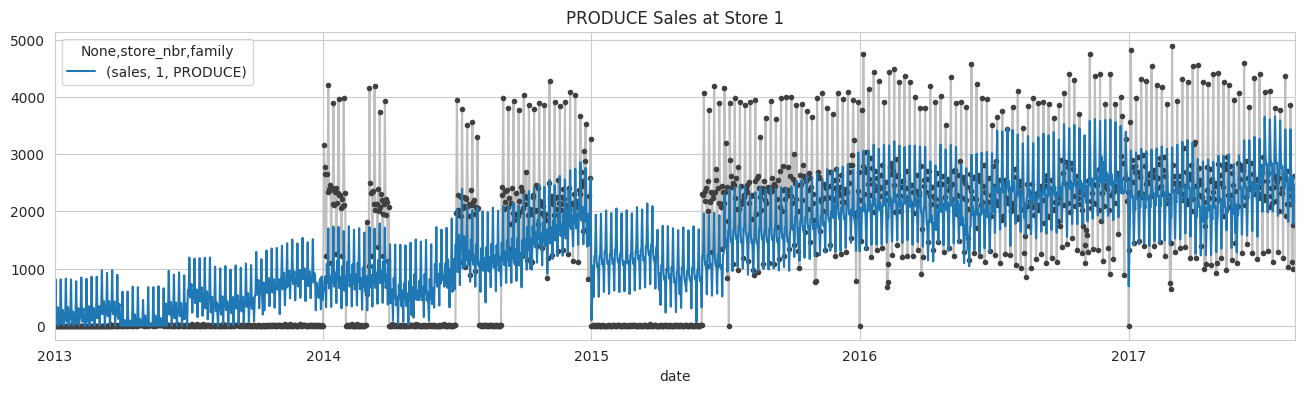

In [265]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

STORE_NBR = '1'  # 1 - 54
FAMILY = 'PRODUCE' # display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)[:, STORE_NBR, FAMILY].plot(**plot_params, figsize=(16, 4))
ax = y_pred_1.loc(axis=1)[:, STORE_NBR, FAMILY].plot(ax=ax)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [ ]:
def create_submission(y_forecast, df_test):
    y_submit = y_forecast.stack(['store_nbr', 'family'])
    y_submit = pd.DataFrame(y_submit, columns=['sales'])
    y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
    y_submit.to_csv('submission.csv', index=False)

In [191]:
# Make submission csv
y_pred_test = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns).clip(0.)

y_pred_test_long = y_pred_test.stack(['store_nbr', 'family']).clip(0.)

sub = pd.read_csv(f"{_data_root_raw}/sample_submission.csv", index_col='id')
sub.sales = y_pred_test_long.values
sub.to_csv("submission.csv", index=True)


Predict Progress


  0%|          | 0/1782 [00:00<?, ?it/s]